#### Importing required pySpark libraries, Configuring Spark and Spark context

In [1]:
import findspark
findspark.init()
import pyspark
conf = pyspark.SparkConf().setAppName("App")
conf = (conf.setMaster('local[*]')
        .set('spark.executor.memory', '4G')
        .set('spark.driver.memory', '10G')
        .set('spark.driver.maxResultSize', '10G'))
sc = pyspark.SparkContext(conf=conf)
from pyspark.sql import SQLContext,SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
sqlc = SQLContext(sc)
spark = SparkSession.builder.getOrCreate()

import matplotlib.pyplot as plt
import seaborn as sns

/opt/anaconda3/lib/python3.8/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


#### Reading data

In [2]:
data = spark.read.format("csv").option("header","true").load("Downloads/creditcard.csv")

In [3]:
data.head()

Row(Time='0', V1='-1.3598071336738', V2='-0.0727811733098497', V3='2.53634673796914', V4='1.37815522427443', V5='-0.338320769942518', V6='0.462387777762292', V7='0.239598554061257', V8='0.0986979012610507', V9='0.363786969611213', V10='0.0907941719789316', V11='-0.551599533260813', V12='-0.617800855762348', V13='-0.991389847235408', V14='-0.311169353699879', V15='1.46817697209427', V16='-0.470400525259478', V17='0.207971241929242', V18='0.0257905801985591', V19='0.403992960255733', V20='0.251412098239705', V21='-0.018306777944153', V22='0.277837575558899', V23='-0.110473910188767', V24='0.0669280749146731', V25='0.128539358273528', V26='-0.189114843888824', V27='0.133558376740387', V28='-0.0210530534538215', Amount='149.62', Class='0')

#### Checking class frequency

In [4]:
classFreq = data.groupBy("Class").count()
classFreq.show()

+-----+------+
|Class| count|
+-----+------+
|    0|284315|
|    1|   492|
+-----+------+



In [5]:
import pandas as pd

In [6]:
toPlot = classFreq.toPandas()

<AxesSubplot:xlabel='Class'>

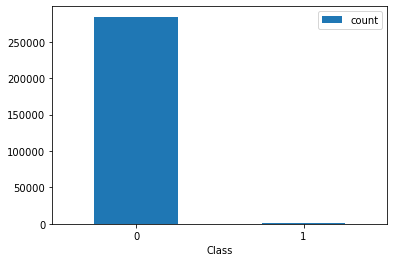

In [7]:
toPlot.plot.bar(x='Class', y='count',rot=0)

#### Converting String data type of column  to double

In [8]:
data.describe

<bound method DataFrame.describe of DataFrame[Time: string, V1: string, V2: string, V3: string, V4: string, V5: string, V6: string, V7: string, V8: string, V9: string, V10: string, V11: string, V12: string, V13: string, V14: string, V15: string, V16: string, V17: string, V18: string, V19: string, V20: string, V21: string, V22: string, V23: string, V24: string, V25: string, V26: string, V27: string, V28: string, Amount: string, Class: string]>

In [9]:
for column in data.columns:
    data = data.withColumn(column,data[column].cast("double"))

In [10]:
data.describe

<bound method DataFrame.describe of DataFrame[Time: double, V1: double, V2: double, V3: double, V4: double, V5: double, V6: double, V7: double, V8: double, V9: double, V10: double, V11: double, V12: double, V13: double, V14: double, V15: double, V16: double, V17: double, V18: double, V19: double, V20: double, V21: double, V22: double, V23: double, V24: double, V25: double, V26: double, V27: double, V28: double, Amount: double, Class: double]>

#### Adding index to keep track of the rows even after shuffling

In [11]:
from pyspark.sql.window import Window
win = Window().orderBy('Time')
data = data.withColumn("idx", row_number().over(win))

#### Importing required Spark ML lib methods

In [12]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import DenseVector

#### Converting the feature columns to dense vector (required by spark) and  creating label and index columns

In [13]:
training_df = data.rdd.map(lambda x: (DenseVector(x[0:29]),x[30],x[31]))

In [14]:
training_df = spark.createDataFrame(training_df,["features","label","index"])

In [15]:
training_df = training_df.select("index","features","label")
training_df.head() 

Row(index=1, features=DenseVector([0.0, -1.3598, -0.0728, 2.5363, 1.3782, -0.3383, 0.4624, 0.2396, 0.0987, 0.3638, 0.0908, -0.5516, -0.6178, -0.9914, -0.3112, 1.4682, -0.4704, 0.208, 0.0258, 0.404, 0.2514, -0.0183, 0.2778, -0.1105, 0.0669, 0.1285, -0.1891, 0.1336, -0.0211]), label=0.0)

#### Splitting data into training and testing data

In [16]:
train_data, test_data = training_df.randomSplit([.8,.2],seed=1234)

In [17]:
train_data.groupBy("label").count().show()

+-----+------+
|label| count|
+-----+------+
|  0.0|227572|
|  1.0|   397|
+-----+------+



In [18]:
test_data.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|56743|
|  1.0|   95|
+-----+-----+



#### Creating Gradient Boosting Trees Classifier Model to fit and predict data

In [19]:
gbt = GBTClassifier(featuresCol="features", maxIter=100,maxDepth=8)

In [20]:
model = gbt.fit(train_data)

In [21]:
predictions = model.transform(test_data)

#### Checking the count of records classified into each classes

In [22]:
predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|56756|
|       1.0|   82|
+----------+-----+



#### Calculating accuracy of model - This can be misleading due to class imbalance

In [23]:
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.944635600774311

#### Calculating percentage of fraud records predicted correctly

In [24]:
predictions = predictions.withColumn("fraudPrediction",when((predictions.label==1)&(predictions.prediction==1),1).otherwise(0))

In [25]:
predictions.groupBy("fraudPrediction").count().show()

+---------------+-----+
|fraudPrediction|count|
+---------------+-----+
|              1|   70|
|              0|56768|
+---------------+-----+



In [26]:
predictions.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|56743|
|  1.0|   95|
+-----+-----+



#### Number of fraud records identified = 96
#### Number of Total fraud records in test dataset = 116
#### Percentage of fraud records identified correctly (Accuracy to identify fraud) = (96/116)*100 = 82.76%

In [27]:
from pyspark.sql.functions import col

In [28]:
accurateFraud = predictions.groupBy("fraudPrediction").count().where(predictions.fraudPrediction==1).head()[1]

In [29]:
totalFraud = predictions.groupBy("label").count().where(predictions.label==1).head()[1]

In [30]:
FraudPredictionAccuracy = (accurateFraud/totalFraud)*100

In [31]:
FraudPredictionAccuracy

73.68421052631578

#### Calculating Confusion matrix

In [32]:
tp = predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()

In [33]:
tn = predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()

In [34]:
fp = predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()

In [35]:
fn = predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()

In [36]:
print("True Positive: ",tp,"\nTrue Negative: ",tn,"\nFalse Positive: ",fp,"\nFalse Negative: ",fn)

True Positive:  70 
True Negative:  56731 
False Positive:  12 
False Negative:  25


In [37]:
lst=[]
lst.append(tp)
lst.append(tn)
lst.append(fp)
lst.append(fn)
lst1=["True Positive: ","True Negative: ","False Positive: ","False Negative: "]

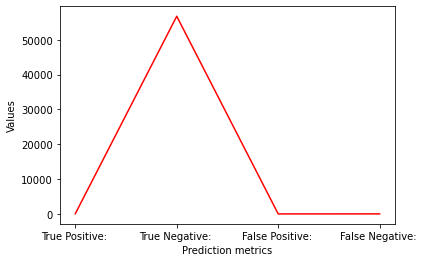

In [38]:
plt.plot(lst1,lst,color='r')
plt.xlabel('Prediction metrics')
plt.ylabel('Values')
plt.show()

### Recall

In [39]:
print("Recall: ",tp/(tp+fn))

Recall:  0.7368421052631579


### Precision

In [40]:
print("Precision: ", tp/(tp+fp))

Precision:  0.8536585365853658


### Accuracy

In [41]:
print("Accuracy: ", (tp+tn)/(tp+fp + tn+fn))


Accuracy:  0.9993490270593617
